In [17]:
import os.path as path
import gpxpy
import matplotlib.pyplot as plt
import datetime
from geopy import distance
from math import sqrt, floor
import numpy as np
import pandas as pd
#import plotly.plotly as py
#import plotly.graph_objs as go
import haversine

# GPX functions

In [18]:
def get_gpx_coordinates(gpx_file_name):
    gpx_df = pd.DataFrame()
    
    longs, lats, hrs, eles, tss = [], [], [], [], []
    
    gpx_file = open(gpx_file_name, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                longs.append(point.longitude)
                lats.append(point.latitude)
                eles.append(point.elevation)
                tss.append(point.time.timestamp())
                for child in point.extensions[0].getchildren():
                    if child.tag[-2:] == 'hr':
                        hrs.append(float(child.text))
                        
    gpx_df['longitude'] = longs
    gpx_df['latitude'] = lats
    gpx_df['elevation'] = eles
    gpx_df['timestamp'] = tss
    gpx_df['hr'] = hrs
    
    return gpx_df

# The input gpx

In [19]:
gpx_folder = path.join(path.expanduser('~'), 'Dropbox')
gpx_folder = path.join(gpx_folder, 'maps')
gpx_folder = path.join(gpx_folder, 'garmin_backup')

In [20]:
gpx_folder = path.join(gpx_folder, '2021')
gpx_folder = path.join(gpx_folder, '01')

In [21]:
gpx_gravel_file_name =  path.join(gpx_folder, '20210126-gravel-quercia_del_monaco_vallecorsa_forcella_buana_via_calamete.gpx')
gpx_running_file_name =  path.join(gpx_folder, '20210122-running-porto_scogli_montuno.gpx')

In [22]:
coordinates = get_gpx_coordinates(gpx_gravel_file_name)

In [23]:
fcmax = 184 # va calcolata meglio

In [24]:
fct = fcmax*.87   # fonte libro Tacchino
fca = fcmax*.8    # CFR

In [25]:
numpoints = coordinates.shape[0]

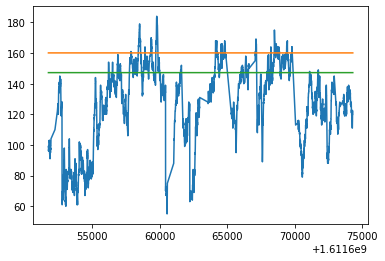

In [26]:
plt.plot(coordinates.timestamp, coordinates.hr)
plt.plot(coordinates.timestamp, [fct]*numpoints)
plt.plot(coordinates.timestamp, [fca]*numpoints)

In [27]:
secondi_totali = coordinates.iloc[-1].timestamp - coordinates.iloc[0].timestamp
secondi_fuori_soglia, secondi_infra_soglie = 0, 0
for p in coordinates[coordinates.hr>=fct].index:
    secondi_fuori_soglia += coordinates.iloc[p].timestamp-coordinates.iloc[p-1].timestamp
for p in coordinates[(coordinates.hr<fct) & (coordinates.hr>=fca)].index:
    secondi_infra_soglie += coordinates.iloc[p].timestamp-coordinates.iloc[p-1].timestamp
secondi_sotto_soglie = secondi_totali-secondi_fuori_soglia-secondi_infra_soglie

([<matplotlib.patches.Wedge at 0x213c11ef6c8>,
 [Text(-0.16903009600547797, 1.1880357009132254, 'Fuori soglia'),
  Text(-0.9018075041268342, 0.7916711599524957, 'Intra soglie'),
  Text(0.7813026724309579, -0.9108052119153929, 'Sotto soglie')],
 [Text(-0.09860088933652882, 0.6930208255327148, '4.5%'),
  Text(-0.5260543774073199, 0.4618081766389558, '18.1%'),
  Text(0.455759892251392, -0.5313030402839791, '77.4%')])

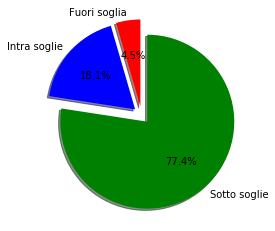

In [28]:
sizes = np.array([secondi_fuori_soglia, secondi_infra_soglie, secondi_sotto_soglie])/secondi_totali
labels = ['Fuori soglia', 'Intra soglie', 'Sotto soglie']
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ('Red', 'Blue', 'Green')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)